In [ ]:
# DO NOT REMOVE

# Catalogue pre-processing
## Settings

In [1]:
%matplotlib inline

import os
import re
import sys
import h5py
import numpy
import subprocess
try:
    import cPickle as pickle
except: 
    import pickle

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from mpl_toolkits.basemap import Basemap

from copy import deepcopy
from oqmbt.oqt_project import OQtProject, OQtModel, OQtSource

from openquake.hmtk.seismicity.occurrence.weichert import Weichert
from openquake.hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971 
from openquake.hmtk.plotting.seismicity.completeness.plot_stepp_1972 import create_stepp_plot
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_trunc_gr_model
from openquake.hmtk.plotting.seismicity.catalogue_plots import (plot_magnitude_time_scatter, 
                                                      plot_magnitude_time_density)
from openquake.hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueParser
from openquake.hmtk.seismicity.selector import CatalogueSelector
from openquake.hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1
from openquake.hmtk.seismicity.declusterer.distance_time_windows import GardnerKnopoffWindow

In [3]:
#
# load project information 
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
oqtkp.directory = os.path.dirname(project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
catalogue_csv_filename = os.path.join(oqtkp.directory, getattr(model,'catalogue_csv_filename'))
#
# info
text_length = 30
print ('{:s}: {:s}'.format('Model id'.ljust(text_length), model_id))
print ('{:s}: {:s}'.format('Reading'.ljust(text_length), catalogue_csv_filename))

Model id                      : model01
Reading                       : /Users/kjohnson/GEM/Regions/paisl18/project/../data/catalogues/locations/FinalCatalog/PI_final.hmtk


In [4]:
#
# cutoff magnitude is the lowest magnitude treshold. All the events below this threshold 
# are filtered out at the beginning of the processing workflow
cutoff_magnitude = float(model.catalogue_cutoff_magnitude)
#
# width of bins used to discretise the MFDs
binwidth = float(model.mfd_binwidth)
#
# printing info
print ('{:s}: {:.2f}'.format('MFD bin width'.ljust(text_length), binwidth))
print ('{:s}: {:.2f}'.format('Magnitude cutoff'.ljust(text_length), cutoff_magnitude))

MFD bin width                 : 0.10
Magnitude cutoff              : 3.50


## Earthquake catalogue

In [5]:
#
# parsing the .csv catalogue
filename = '/Users/kjohnson/GEM/Regions/paisl18/data/catalogues/locations/FinalCatalog/PI_final.hmtk'
catalogue_parser = CsvCatalogueParser(catalogue_csv_filename)
catalogue = catalogue_parser.read_file()
selector = CatalogueSelector(catalogue, create_copy=False)
selector.within_magnitude_range(cutoff_magnitude, 10.)
dep_max = float(model.catalogue_maximum_depth)
dep_min = float(model.catalogue_minimum_depth)
tmp = selector.within_depth_range(dep_max, dep_min)
#
# info
print ('Catalogue:')
print ('    minimum hypocentral depth: {:.2f}'.format(numpy.min(catalogue.data['depth'])))
print ('    maximum hypocentral depth: {:.2f}'.format(numpy.max(catalogue.data['depth'])))

Catalogue Attribute field_28 is not a recognised catalogue key
Catalogue Attribute field_29 is not a recognised catalogue key
Catalogue Attribute field_24 is not a recognised catalogue key
Catalogue Attribute field_26 is not a recognised catalogue key
Catalogue Attribute locId is not a recognised catalogue key
Catalogue Attribute MagId is not a recognised catalogue key
Catalogue Attribute field_23 is not a recognised catalogue key
Catalogue Attribute field_30 is not a recognised catalogue key
Catalogue Attribute Identifier is not a recognised catalogue key
Catalogue Attribute field_25 is not a recognised catalogue key
Catalogue Attribute 360_1 is not a recognised catalogue key
Catalogue Attribute field_27 is not a recognised catalogue key
Catalogue:
    minimum hypocentral depth: 0.00
    maximum hypocentral depth: 34.90


/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/selector.py:380: RuntimeWarning: invalid value encountered in greater_equal
  is_valid = np.logical_and(self.catalogue.data['depth'] >= upper_depth,
/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/selector.py:381: RuntimeWarning: invalid value encountered in less
  self.catalogue.data['depth'] < lower_depth)


In [6]:
if 0: 
    import cartopy
    import cartopy.crs as ccrs
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    
    fig = plt.figure(figsize=(20, 14), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    
    if 'map_limits' in model.__dict__:
        limits = model.map_limits
        tickspacing = model.map_tick_spacing
    else:
        limits = [min(catalogue.data['longitude']), min(catalogue.data['latitude']), 
                  max(catalogue.data['longitude']), max(catalogue.data['latitude'])]
        if limits[2]-limits[0] > 20:
            tickspacing = 10
        else:
            tickspacing = 5
    
    ax.coastlines()
    # ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    # set the area for the plot
    ax.set_extent([limits[0], limits[2], limits[1], limits[3]], ccrs.Geodetic())
    
    xlo = numpy.floor(limits[0]/10)*10
    ylo = numpy.round(limits[1]/10)*10
    ax.set_xticks(numpy.arange(xlo, limits[2], tickspacing), crs=ccrs.PlateCarree())
    ax.set_yticks(numpy.arange(ylo, limits[3], tickspacing), crs=ccrs.PlateCarree())
    
    idx = numpy.nonzero(flag!=0)

    # catalogue    
    ax.plot(catalogue.data['longitude'], catalogue.data['latitude'], 'o',
            linewidth=6, alpha=0.4, transform=ccrs.Geodetic(), color='blue')

    ax.plot(catalogue_original.data['longitude'][idx], 
            catalogue_original.data['latitude'][idx], 'x',
            linewidth=.5, alpha=0.8, transform=ccrs.Geodetic(), color='red')   

### Declustering

In [7]:
distance_time_wind = GardnerKnopoffWindow()
config = {'time_distance_window': distance_time_wind, 'fs_time_prop': .9}
declusterer = GardnerKnopoffType1()
vcl, flag = declusterer.decluster(catalogue, config)

In [8]:
catalogue_original = deepcopy(catalogue)
print ('{:s}: {:.2f}'.format('Original number of events'.ljust(text_length), catalogue_original.get_number_events()))
catalogue.select_catalogue_events(numpy.where(flag == 0)[0])
print ('{:s}: {:.2f}'.format('Number of mainshocks'.ljust(text_length), len(catalogue.data['magnitude'])))

Original number of events     : 7523.00
Number of mainshocks          : 2867.00


### Completeness analysis

In [9]:
print(min(catalogue.data['year']), max(catalogue.data['year']))
print(min(catalogue.data['month']), max(catalogue.data['month']))
print(min(catalogue.data['day']), max(catalogue.data['day']))

1900 2014
1 12
1 31


In [10]:
#
# parameters for completeness analysis
config = {'magnitude_bin': .5, 'time_bin': 10., 'increment_lock': True}
stepp = Stepp1971()
compl_table = stepp.completeness(catalogue, config)
#
# cleaning temporary figures
if os.path.exists('aa'):
    subprocess.call('rm aa', shell=True)
#create_stepp_plot(stepp, 'aa')
if os.path.exists('aa'):
    subprocess.call('rm aa', shell=True)
#
# info
print ('Maximum magnitude is: ', max(catalogue.data['magnitude']))
print ('The catalogue contains %d events' % (catalogue.get_number_events()))
print ('Completeness table: \n')
#
# Display html
for line in compl_table:
    print ('%.2f, %.2f' % (line[0], line[1]))

Maximum magnitude is:  8.2
The catalogue contains 2867 events
Completeness table: 

1969.00, 5.00
1969.00, 5.50
1931.00, 6.00
1931.00, 6.50
1931.00, 7.00
1931.00, 7.50
1931.00, 8.00


2010.0 5.0
1969.0 5.0
1969.0 5.5
1931.0 6.0
1931.0 6.5
1931.0 7.0
1931.0 7.5
1931.0 8.0
1900.0 8.0


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


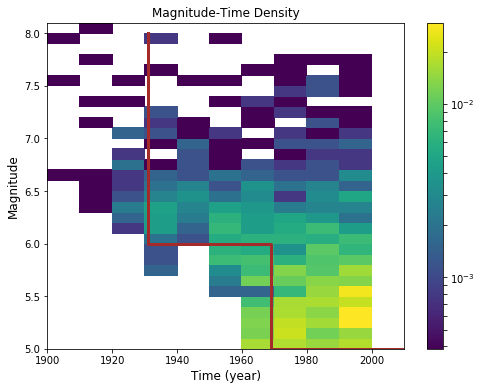

In [11]:
ppp = plot_magnitude_time_density(catalogue, mag_int=0.1, time_int=10, normalisation=True, 
                                  bootstrap=0, completeness=compl_table)

## Magnitude-frequency distribution

In [12]:
idx = numpy.nonzero(compl_table[:,1] < numpy.max(catalogue.data['magnitude']))
#
# settings for MFD calculation
weichert_config = {'magnitude_interval': 0.1, 'reference_magnitude': 0.0}
weichert = Weichert()
bval_wei, sigmab, aval_wei, sigmaa = weichert.calculate(catalogue, weichert_config, completeness=compl_table)
#
# info
print ('bval: %.3f (sigma=%.3f)' % (bval_wei, sigmab))
print ('aval: %.3f (sigma=%.3f)' % (aval_wei, sigmaa))

bval: 0.756 (sigma=0.014)
aval: 5.466 (sigma=0.009)


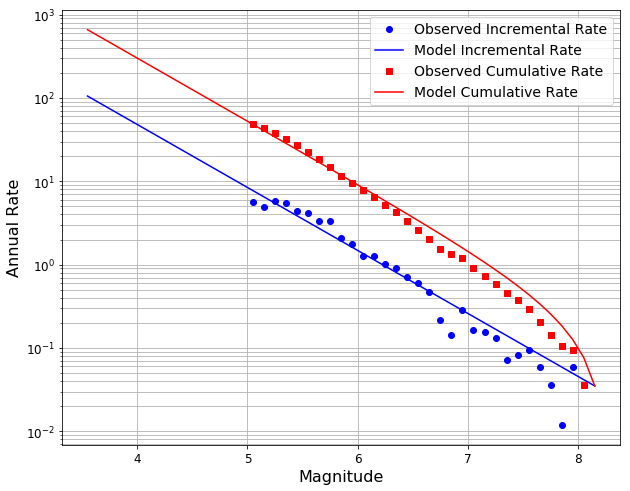

In [13]:
mmax_plot = numpy.amax(catalogue.data['magnitude'])
plot_trunc_gr_model(aval_wei, bval_wei, cutoff_magnitude, mmax_plot, 0.1, catalogue=catalogue, completeness=compl_table)

## Project info

In [14]:
model_lab = re.sub('\s', '_', oqtkp.models[model_id].name).lower()
output_path = os.path.join(oqtkp.directory, '%s_catalogue.pkl' % model_lab)
fou = open(output_path,'wb') 
pickle.dump(catalogue, fou)
fou.close()
print ('Catalogue dataset saved into file: \n%s' % (output_path))

Catalogue dataset saved into file: 
/Users/kjohnson/GEM/Regions/paisl18/project/model_1_-_learning_catalogue.pkl


In [15]:
filename = os.path.join(oqtkp.directory, oqtkp.compl_hdf5_filename)
fhdf5 = h5py.File(filename, 'a')
print ('Updating {:s}'.format(filename))
dataset_name = 'whole_catalogue'
#
# Update/create group
if model_id in fhdf5.keys():
    print ('    Group {:s} exists'.format(model_id))
    grp = fhdf5[model_id]
else:
    print ('    Creating group: %s' % (model_id))
    grp = fhdf5.create_group(model_id)
# Update/create dataset
if dataset_name in grp:
    del fhdf5[model_id][dataset_name]
    print ('    Updating dataset: %s' % (dataset_name))
    dataset = grp.create_dataset(dataset_name, data=compl_table)
else:
    print ('    Creating dataset: %s' % (dataset_name))
    dataset = grp.create_dataset(dataset_name, data=compl_table)
fhdf5.close()

Updating /Users/kjohnson/GEM/Regions/paisl18/project/completeness.hdf5
    Group model01 exists
    Creating dataset: whole_catalogue


In [16]:
oqtkp.models[model_id].declustered_catalogue_pickle_filename = os.path.relpath(output_path, oqtkp.directory)
oqtkp.save()

In [17]:
model = oqtkp.models[model_id]
model.get_info()


Information for model: Model 1 - learning
   area_discretization                     : 10.0
   area_shapefile_filename                 : ./../data/sources_area/areas_KJ_v1.shp
   catalogue_csv_filename                  : ../data/catalogues/locations/FinalCatalog/PI_final.hmtk
   catalogue_cutoff_magnitude              : 3.5
   catalogue_lower_hypo_depth              : 35.0
   catalogue_maximum_depth                 : 35.0
   catalogue_minimum_depth                 : 0.0
   declustered_catalogue_pickle_filename   : model_1_-_learning_catalogue.pkl
   fault_rupt_aspect_ratio                 : 2.0
   fault_rupture_mesh_spacing              : 5.0
   focal_mechanisms_filename               : ../data/catalogue/focal_mechanisms/GCMT_20151231.ndk
   hypo_depth_bin_edges                    : [0, 15, 35]
   hypo_dist_filename                      : model01_hypo_dist.hdf5
   id                                      : model01
   m_min                                   : 5.0
   magnitude_max_delta 